maybe this kernel is a rehash of https://www.kaggle.com/yag320/list-of-fake-samples-and-public-private-lb-split .

In [1]:
import gc
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from multiprocessing import Pool

import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
PATH="../input/"
os.listdir(PATH)

['sample_submission.csv', 'test.csv', 'train.csv']

In [2]:
def merge_train_test(df_train, df_test):
    if "target" not in df_test.columns.values:
        df_test["target"] = -1
    res = pd.concat([df_train, df_test])
    res.reset_index(inplace=True, drop=True)
    return res

def split_train_test(df):
    df_train = df[df["target"] >= 0]
    df_test = df[df["target"] <= -1]
    df_train.reset_index(inplace=True, drop=True)
    df_test.reset_index(inplace=True, drop=True)
    assert list(df_train["ID_code"].values) == [f"train_{i}" for i in range(200000)]
    assert list(df_test["ID_code"].values) == [f"test_{i}" for i in range(200000)]
    return df_train, df_test

In [3]:
%%time
train_df = pd.read_csv(PATH+"train.csv")
test_df = pd.read_csv(PATH+"test.csv")

CPU times: user 15.8 s, sys: 1.07 s, total: 16.8 s
Wall time: 16.9 s


## 1. real/fake split

In [4]:
class CountEncoder:
    def fit(self, series):
        self.counts = series.groupby(series).count()
    
    def transform(self, series):
        return series.map(self.counts).fillna(0).astype(np.int16)

count encoding with all data. since I had known count encoding improves CV (also LB, but little), I guessed there are some secret in count encoding.

In [5]:
%%time
df_merged = merge_train_test(train_df, test_df)
for i in range(200):
    enc = CountEncoder()
    var = df_merged[f"var_{i}"]
    enc.fit(var)
    df_merged[f"{i}_count_enc"] = enc.transform(var)

CPU times: user 17.8 s, sys: 1.21 s, total: 19.1 s
Wall time: 19.1 s


compare the mean of count of train and test.

In [6]:
train_df, test_df = split_train_test(df_merged)
for v in range(10):
    cnt_mean_trn = train_df[f"{v}_count_enc"].mean()
    cnt_mean_test = test_df[f"{v}_count_enc"].mean()
    print(f"cnt_mean_trn={cnt_mean_trn:2.5f}, cnt_mean_test={cnt_mean_test:2.5f}, diff={cnt_mean_trn-cnt_mean_test:.5f}")

cnt_mean_trn=4.85306, cnt_mean_test=6.34436, diff=-1.49130
cnt_mean_trn=3.93603, cnt_mean_test=5.43168, diff=-1.49565
cnt_mean_trn=5.44160, cnt_mean_test=6.94752, diff=-1.50592
cnt_mean_trn=6.41312, cnt_mean_test=7.87322, diff=-1.46009
cnt_mean_trn=7.79709, cnt_mean_test=9.30327, diff=-1.50618
cnt_mean_trn=2.54268, cnt_mean_test=4.03948, diff=-1.49680
cnt_mean_trn=14.01893, cnt_mean_test=15.54105, diff=-1.52212
cnt_mean_trn=4.19487, cnt_mean_test=5.69018, diff=-1.49531
cnt_mean_trn=4.48427, cnt_mean_test=5.99355, diff=-1.50928
cnt_mean_trn=10.12020, cnt_mean_test=11.59561, diff=-1.47541


count of test data is 1.5 larger than train data. strange...

then checked: how many `count_enc==1` in the same row?

In [7]:
%%time
df_merged["count_enc_1s"] = 0
for v in range(200):
    df_merged["count_enc_1s"] += (df_merged[f"{v}_count_enc"]==1)
train_df, test_df = split_train_test(df_merged)

CPU times: user 1.32 s, sys: 540 ms, total: 1.86 s
Wall time: 1.59 s


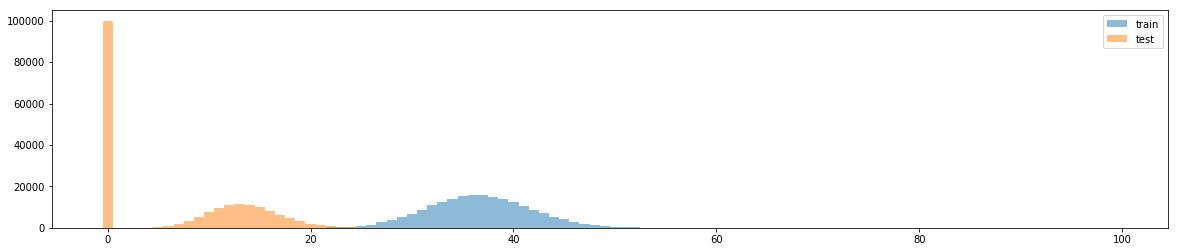

In [8]:
plt.figure(figsize=(20, 4))
plt.hist(train_df["count_enc_1s"], range=(-0.5, 99.5), bins=100, alpha=0.5, label="train")
plt.hist(test_df["count_enc_1s"], range=(-0.5, 99.5), bins=100, alpha=0.5, label="test")
plt.legend()
plt.show()

!?!?!?

`count_enc_1s==0` can mean all values in the row are duplicated.

how many `count_enc_1s==0` rows?

In [9]:
(test_df["count_enc_1s"]==0).sum()

100000

I submitted a file and found that the rows with `count_enc_1s==0` does not affect public LB.  
so I thought those are private data.

In [10]:
test_df["target"] = -1 - (test_df["count_enc_1s"] == 0)  # -1: public?  -2: private?
test_df.head()

# actually -1 is real and -2 is fake

,ID_code,target,var_0,var_1,var_10,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_11,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_12,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_13,var_130,var_131,...,161_count_enc,162_count_enc,163_count_enc,164_count_enc,165_count_enc,166_count_enc,167_count_enc,168_count_enc,169_count_enc,170_count_enc,171_count_enc,172_count_enc,173_count_enc,174_count_enc,175_count_enc,176_count_enc,177_count_enc,178_count_enc,179_count_enc,180_count_enc,181_count_enc,182_count_enc,183_count_enc,184_count_enc,185_count_enc,186_count_enc,187_count_enc,188_count_enc,189_count_enc,190_count_enc,191_count_enc,192_count_enc,193_count_enc,194_count_enc,195_count_enc,196_count_enc,197_count_enc,198_count_enc,199_count_enc,count_enc_1s
0,test_0,-2,11.0656,7.7798,-2.0248,-9.2198,17.3089,30.9548,1.4918,12.8721,3.4902,8.2856,11.9794,14.0176,15.0763,-4.3554,3.7662,6.0426,4.4243,14.1799,2.0921,1.5493,3.2206,0.0172,-6.6602,8.4785,13.9696,42.0248,11.4164,0.4564,9.4006,0.9685,12.4929,14.1240,4.0388,-4.4442,16.6684,0.3458,12.5380,0.9205,...,45,8,6,4,3,51,6,6,20,10,7,5,4,4,8,5,9,2,14,2,16,5,6,3,5,13,2,6,19,5,3,3,12,4,5,8,7,7,5,0
1,test_1,-2,8.5304,1.2543,-1.3809,-1.7257,15.4712,35.6020,1.6570,13.0783,2.7752,6.4986,4.6835,13.7963,17.7261,-0.3310,1.7375,5.5689,3.6609,8.9725,4.1159,1.0693,2.0234,8.2760,-6.8610,0.2780,14.1129,17.0488,11.6704,3.1215,8.5093,5.6367,12.0099,14.2372,-6.1600,-5.6690,8.9094,2.5667,11.0605,0.4583,...,67,8,5,4,4,26,6,13,27,6,5,4,2,5,3,5,5,3,4,4,10,3,5,2,3,7,7,4,16,4,8,17,4,5,26,4,15,5,7,0
2,test_2,-2,5.4827,-10.3581,-4.7057,-3.5065,14.1663,28.0256,1.3935,10.8257,4.2954,8.2125,26.2595,14.0232,19.4604,-3.0422,8.6896,8.1036,1.2057,8.9156,0.9777,2.3797,3.1638,37.8664,-3.3864,-2.4090,13.6751,29.7978,12.2056,4.7688,7.9344,2.2102,12.6482,14.3377,2.3268,2.3930,13.7005,3.8183,12.7047,0.7507,...,55,11,4,4,3,49,4,4,25,9,8,6,2,2,5,5,9,4,5,7,7,2,4,7,7,6,4,3,15,5,6,13,5,5,6,3,7,6,2,0
3,test_3,-1,8.5374,-1.3222,0.0095,1.7021,2.5363,3.8763,1.5173,13.4083,2.8965,7.0919,21.6304,14.2000,23.0368,-5.0659,10.3445,6.0369,5.0227,12.6600,2.1278,4.0592,1.9084,11.6095,7.5397,8.1972,14.0526,20.0844,10.4440,8.4676,5.0350,4.3103,12.0067,13.7149,1.6143,-1.2328,22.7248,13.5010,12.6609,0.8039,...,56,11,4,6,3,32,6,7,37,2,5,2,9,4,12,6,8,3,11,4,22,5,5,3,1,2,2,9,11,5,3,12,5,4,7,2,10,9,3,16
4,test_4,-2,11.7058,-0.1327,5.1025,-14.3858,17.8630,23.2274,1.4375,14.4838,4.3806,10.6976,18.4023,14.2212,16.0638,-3.2827,6.3933,6.8699,2.7253,12.6458,3.2376,3.4218,-0.5658,-5.6840,4.7753,10.3320,14.1013,39.7127,11.2319,-1.2978,12.4827,6.5034,12.7157,13.3054,-1.9678,-1.2363,11.5686,8.9672,12.6428,0.4792,...,63,11,4,4,6,44,8,2,22,10,5,5,4,4,11,3,14,5,5,11,10,4,3,7,3,8,4,6,21,6,6,11,7,6,21,3,8,6,6,0


## 2. public/private split

I found that:  
*all values in private? data also appears in public? data.*

In [11]:
%%time
for val, df_grouped in test_df.groupby(f"var_{v}"):
    if -2 in df_grouped["target"].values:
        assert -1 in df_grouped["target"].values
print("ok")

ok
CPU times: user 22.7 s, sys: 252 ms, total: 22.9 s
Wall time: 22.9 s


so it can be said that all values in private? data are duplicated from public? data.

then I thought:  
*the target of data duplicated from `target==1` is 1?*

if the value which is unique in public? data appeares in some private data, maybe those have the same target value.  
(cf. graph features in Quora Question Pairs)

In [12]:
# unionfind tree
class Uf:
    def __init__(self, N):
        self.Par = list(range(N))

    def root(self, x):
        if self.Par[x] == x:
            return x
        else:
            self.Par[x] = self.root(self.Par[x])
            return self.Par[x]

    def same(self, x, y):
        return self.root(x) == self.root(y)

    def unite(self, x, y):
        x = self.root(x)
        y = self.root(y)
        if x != y:
            self.Par[x] = y

In [13]:
%%time
from itertools import groupby
from operator import itemgetter

index = range(200000)
target = test_df["target"].values

uf = Uf(200000)
for v in range(200):
    data = test_df[f"var_{v}"].values
    for k, g in groupby(sorted(zip(data, target, index)), key=itemgetter(0)):  # grouping by raw value
        g = list(g)
        if [tgt for _, tgt, _ in g].count(-1) == 1:  # if the value is unique in public? data
            idx0 = g[0][2]
            for _, _, idx in g[1:]:
                uf.unite(idx0, idx)  # belong to same group

CPU times: user 3min 19s, sys: 140 ms, total: 3min 19s
Wall time: 3min 19s


In [14]:
from collections import defaultdict
cnt = defaultdict(int)
for i in test_df.index.values:
    cnt[uf.root(i)] += 1
cnt

defaultdict(int, {166779: 100000, 176921: 100000})

In [15]:
cnt = defaultdict(int)
for i in test_df[target==-1].index.values:
    cnt[uf.root(i)] += 1
cnt

defaultdict(int, {176921: 50000, 166779: 50000})

In [16]:
cnt = defaultdict(int)
for i in test_df[target==-2].index.values:
    cnt[uf.root(i)] += 1
cnt

defaultdict(int, {166779: 50000, 176921: 50000})

public? and private? were split into two groups.

then I found one of the group does not affect LB.  
so I was confused but my teammate mamas suggested private? was not private, but fake.

we finally found true public/private split and real/fake split.

In [18]:
test_df["public_private"] = [uf.root(idx)==166779 for idx in range(200000)]
test_df.head()

,ID_code,target,var_0,var_1,var_10,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_11,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_12,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_13,var_130,var_131,...,162_count_enc,163_count_enc,164_count_enc,165_count_enc,166_count_enc,167_count_enc,168_count_enc,169_count_enc,170_count_enc,171_count_enc,172_count_enc,173_count_enc,174_count_enc,175_count_enc,176_count_enc,177_count_enc,178_count_enc,179_count_enc,180_count_enc,181_count_enc,182_count_enc,183_count_enc,184_count_enc,185_count_enc,186_count_enc,187_count_enc,188_count_enc,189_count_enc,190_count_enc,191_count_enc,192_count_enc,193_count_enc,194_count_enc,195_count_enc,196_count_enc,197_count_enc,198_count_enc,199_count_enc,count_enc_1s,public_private
0,test_0,-2,11.0656,7.7798,-2.0248,-9.2198,17.3089,30.9548,1.4918,12.8721,3.4902,8.2856,11.9794,14.0176,15.0763,-4.3554,3.7662,6.0426,4.4243,14.1799,2.0921,1.5493,3.2206,0.0172,-6.6602,8.4785,13.9696,42.0248,11.4164,0.4564,9.4006,0.9685,12.4929,14.1240,4.0388,-4.4442,16.6684,0.3458,12.5380,0.9205,...,8,6,4,3,51,6,6,20,10,7,5,4,4,8,5,9,2,14,2,16,5,6,3,5,13,2,6,19,5,3,3,12,4,5,8,7,7,5,0,True
1,test_1,-2,8.5304,1.2543,-1.3809,-1.7257,15.4712,35.6020,1.6570,13.0783,2.7752,6.4986,4.6835,13.7963,17.7261,-0.3310,1.7375,5.5689,3.6609,8.9725,4.1159,1.0693,2.0234,8.2760,-6.8610,0.2780,14.1129,17.0488,11.6704,3.1215,8.5093,5.6367,12.0099,14.2372,-6.1600,-5.6690,8.9094,2.5667,11.0605,0.4583,...,8,5,4,4,26,6,13,27,6,5,4,2,5,3,5,5,3,4,4,10,3,5,2,3,7,7,4,16,4,8,17,4,5,26,4,15,5,7,0,False
2,test_2,-2,5.4827,-10.3581,-4.7057,-3.5065,14.1663,28.0256,1.3935,10.8257,4.2954,8.2125,26.2595,14.0232,19.4604,-3.0422,8.6896,8.1036,1.2057,8.9156,0.9777,2.3797,3.1638,37.8664,-3.3864,-2.4090,13.6751,29.7978,12.2056,4.7688,7.9344,2.2102,12.6482,14.3377,2.3268,2.3930,13.7005,3.8183,12.7047,0.7507,...,11,4,4,3,49,4,4,25,9,8,6,2,2,5,5,9,4,5,7,7,2,4,7,7,6,4,3,15,5,6,13,5,5,6,3,7,6,2,0,False
3,test_3,-1,8.5374,-1.3222,0.0095,1.7021,2.5363,3.8763,1.5173,13.4083,2.8965,7.0919,21.6304,14.2000,23.0368,-5.0659,10.3445,6.0369,5.0227,12.6600,2.1278,4.0592,1.9084,11.6095,7.5397,8.1972,14.0526,20.0844,10.4440,8.4676,5.0350,4.3103,12.0067,13.7149,1.6143,-1.2328,22.7248,13.5010,12.6609,0.8039,...,11,4,6,3,32,6,7,37,2,5,2,9,4,12,6,8,3,11,4,22,5,5,3,1,2,2,9,11,5,3,12,5,4,7,2,10,9,3,16,False
4,test_4,-2,11.7058,-0.1327,5.1025,-14.3858,17.8630,23.2274,1.4375,14.4838,4.3806,10.6976,18.4023,14.2212,16.0638,-3.2827,6.3933,6.8699,2.7253,12.6458,3.2376,3.4218,-0.5658,-5.6840,4.7753,10.3320,14.1013,39.7127,11.2319,-1.2978,12.4827,6.5034,12.7157,13.3054,-1.9678,-1.2363,11.5686,8.9672,12.6428,0.4792,...,11,4,4,6,44,8,2,22,10,5,5,4,4,11,3,14,5,5,11,10,4,3,7,3,8,4,6,21,6,6,11,7,6,21,3,8,6,6,0,True
